<a href="https://colab.research.google.com/github/IamLucifer0312/Furniture-Recognition-CNN/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the Furniture dataset, there are 06 categories: beds  - 6578 images; chairs  - 22053 images;
dressers - 7871 images; lamps  - 32402 images; sofas  - 4080 images; tables - 17100 images,
with total of 90084 images. For every category, there are 17 interior styles:
(a) Asian; (b) Beach; (c) Contemp; (d) Craftsman; (e) Eclectic; (f) Farmhouse; (g) Industrial
(h) Media; (i) Midcentury; (j) Modern; (k) Rustic; (l) Scandinavian; (m) Southwestern
(n) Traditional; (o) Transitional; (p) Tropical and (q) Victorian

### Task 2: Recommend 10 furniture items in our dataset which is similar to the input furniture item image from users. You are required to define a metric of “similarity” between two furniture items.

### First, mount the Google Drive to start downloading necessary files


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Now download and extract the original dataset

In [ ]:
import gdown

# Google Drive file ID (from the shared link)
file_id = "1h2SIWZZUESO6xygzF4iMkK-tVc4mZ27M"
file_name = "Furniture_Data.zip"
file_path = "/content/" + file_name

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name, quiet=False)
print(f"Downloaded: {file_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1h2SIWZZUESO6xygzF4iMkK-tVc4mZ27M
From (redirected): https://drive.google.com/uc?id=1h2SIWZZUESO6xygzF4iMkK-tVc4mZ27M&confirm=t&uuid=da23dc51-2458-4030-b438-f32844bb6a79
To: /content/Furniture_Data.zip
100%|██████████| 2.49G/2.49G [00:39<00:00, 62.8MB/s]

Downloaded: /content/Furniture_Data.zip


In [ ]:
!unzip -q $file_path -d /content/extracted_folder

replace /content/extracted_folder/Furniture_Data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Define the categories


In [ ]:
categories = ['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']

### Now we remove all duplicated images in all classes using hash. This reduces the time to convert the dataset to features, and avoid recommending similar images

In [ ]:
import hashlib
from PIL import Image
import cv2
import random
import os

# Define the original dataset path
original_dataset_path = '/content/extracted_folder/Furniture_Data'

# Function to compute image hash
def get_image_hash(image_path):
    """Generate an MD5 hash for an image file."""
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Store unique images and duplicates
hashes = {}
deleted_count = 0



# Loop through all categories and subfolders
for category in os.listdir(original_dataset_path):
    category_path = os.path.join(original_dataset_path, category)

    if os.path.isdir(category_path):  # Ensure it's a directory
        for style in os.listdir(category_path):
            style_path = os.path.join(category_path, style)

            if os.path.isdir(style_path):  # Ensure it's a directory
                for image in os.listdir(style_path):
                    img_path = os.path.join(style_path, image)
                    img_hash = get_image_hash(img_path)

                    if img_hash in hashes:
                        os.remove(img_path)  # Delete duplicate image
                        deleted_count += 1
                        print(f"Deleted: {img_path}")
                    else:
                        hashes[img_hash] = img_path  # Store first occurrence


# Report results
print(f"\n Removed {deleted_count} duplicate images.")

Deleted: /content/extracted_folder/Furniture_Data/beds/Beach/4959beach-style-panel-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Beach/8137beach-style-bunk-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Southwestern/5537southwestern-panel-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Farmhouse/8410farmhouse-platform-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Farmhouse/8384farmhouse-bunk-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Contemporary/630contemporary-bunk-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Contemporary/1438contemporary-panel-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Contemporary/1447contemporary-platform-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Contemporary/909contemporary-kids-beds.jpg
Deleted: /content/extracted_folder/Furniture_Data/beds/Contemporary/473contemporary-panel-beds.jpg
Deleted: /content/extracted_f

### Get the path array of all images

In [24]:
import os
# Initialize an empty list to store image paths
image_paths = []
original_dataset_path = '/content/extracted_folder/Furniture_Data'


# Loop through all categories and subfolders
for category in os.listdir(original_dataset_path):
    category_path = os.path.join(original_dataset_path, category)

    if os.path.isdir(category_path):  # Ensure it's a directory
        for style in os.listdir(category_path):
            style_path = os.path.join(category_path, style)

            if os.path.isdir(style_path):  # Ensure it's a directory
                for image in os.listdir(style_path):
                    image_path = os.path.join(style_path, image)
                    image_paths.append(image_path)  # Add to list

# Print sample image paths
print("Total images found:", len(image_paths))
print("Sample paths:", image_paths[:5])  # Print first 5 paths


Total images found: 85165
Sample paths: ['/content/extracted_folder/Furniture_Data/tables/Transitional/21695transitional-console-tables.jpg', '/content/extracted_folder/Furniture_Data/tables/Transitional/28742transitional-side-tables-and-end-tables.jpg', '/content/extracted_folder/Furniture_Data/tables/Transitional/28903transitional-coffee-tables.jpg', '/content/extracted_folder/Furniture_Data/tables/Transitional/28818transitional-side-tables-and-end-tables.jpg', '/content/extracted_folder/Furniture_Data/tables/Transitional/21217transitional-coffee-tables.jpg']


### Download and reload the model we used for task 1

In [ ]:
import gdown

# Google Drive file ID (from the shared link)
file_id = "1Jqgsc8NznuETPFeSpH3cjXVO-Nxex915"
file_name = "best_furniture_model.h5"
file_path = "/content/" + file_name

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name, quiet=False)
print(f"Downloaded: {file_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1Jqgsc8NznuETPFeSpH3cjXVO-Nxex915
From (redirected): https://drive.google.com/uc?id=1Jqgsc8NznuETPFeSpH3cjXVO-Nxex915&confirm=t&uuid=7bf362a2-42e3-42ca-b468-1ff5e85478b6
To: /content/best_furniture_model.h5
100%|██████████| 3.09G/3.09G [00:22<00:00, 137MB/s]

Downloaded: /content/best_furniture_model.h5


In [14]:
import keras
from tensorflow.keras.models import Model

model = keras.saving.load_model("/content/best_furniture_model.h5")


model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 640)                 │     256,901,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,846 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,533,832 (982.41 MB)

 Trainable params: 257,533,830 (982.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

As we can see in the model summary, our model unluckily has no input class, and handle the classification task with the last two layers. Therefore, if we only get the output of the previous fully-connected layers as the model's output, we can get the embedded vector features of images.

### Use the first layer as the input layer (Images need to be preprocessed to the right shape before feeding to the mode), then slice the last two layers by taking the previous Dense layer as output.

In [15]:
# Get the first layer as input
input_layer = model.layers[0].input  # Explicitly using the first layer's input

# Identify the last convolutional or pooling layer before Flatten
output_layer = model.get_layer("dense_2").output  # Extract features before Flatten

# Create a new model for feature extraction
feature_extractor = Model(inputs=input_layer, outputs=output_layer)

# Print summary to verify
feature_extractor.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 640)                 │     256,901,760 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,529,984 (982.40 MB)

 Trainable params: 257,529,984 (982.40 MB)

 Non-trainable params: 0 (0.00 B)

### Define the function to normalize and preprocess images

In [1]:
import numpy as np
import tensorflow as tf

def preprocess_image(image_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB

    # Resize to (224, 224)
    image = tf.image.resize(image, (224, 224))

    # Normalize to [0, 1] range
    image = image / 255.0

    # Add batch dimension
    image = np.expand_dims(image, axis=0)  # Shape becomes (1, 224, 224, 3)

    return image


### Define the function to extract embeddings from image paths and flatten the result (for easy comparison)

In [12]:
def extract_features(image_path):
  image_arr = preprocess_image(image_path)
  features = feature_extractor.predict(image_arr, verbose = 0)
  return features.flatten()


### Run through all images in the dataset and extract their features, then put them all into a file

In [ ]:
feature_vectors = []
for img_path in image_paths:
    features = extract_features(img_path)  # Extract feature vector (implement this function)
    feature_vectors.append(features)

# Convert to NumPy array
feature_vectors = np.array(feature_vectors)
np.save("furniture_features.npy", feature_vectors)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

### Load the image features file and double-check the shape and size

In [9]:
import numpy as np

# Load the .npy file
feature_vectors = np.load("furniture_features.npy")

# Print shape and size
print(feature_vectors.shape)
print("Size:", feature_vectors.size)    # Total number of elements


(85165, 640)
Size: 54505600


Now we feed the features to the KNN, so it can memorize them. We also set the k number to 10, meaning the KNN algorithm will take a cluster of 10, which corresponds to our task to recommend 10 images

In [66]:
from sklearn.neighbors import NearestNeighbors
import joblib


knn = NearestNeighbors(n_neighbors=10, metric="cosine")
knn.fit(feature_vectors)  # Fit all feature vectors
joblib.dump(knn, "knn_model_cosine.pkl")  # Save trained model


['knn_model_cosine.pkl']

### Now try loading an image and test the result

In [79]:
query_path = "/content/image9.jpeg"
query_vector = extract_features(query_path)
distances, indices = knn.kneighbors([query_vector])  # Find k nearest neighbors


In [51]:
print(indices[:10])

[[19079 81407 81987 22546 21585 19378 19908 83615 84581 21688]]


In [80]:
responses = [image_paths[i] for i in indices[0]]
print(responses)

['/content/extracted_folder/Furniture_Data/beds/Traditional/7374traditional-panel-beds.jpg', '/content/extracted_folder/Furniture_Data/beds/Transitional/10234transitional-panel-beds.jpg', '/content/extracted_folder/Furniture_Data/beds/Traditional/6451traditional-daybeds.jpg', '/content/extracted_folder/Furniture_Data/beds/Contemporary/118contemporary-platform-beds.jpg', '/content/extracted_folder/Furniture_Data/beds/Traditional/5316traditional-panel-beds.jpg', '/content/extracted_folder/Furniture_Data/beds/Contemporary/314contemporary-panel-beds.jpg', '/content/extracted_folder/Furniture_Data/beds/Victorian/10497victorian-canopy-beds.jpg', '/content/extracted_folder/Furniture_Data/beds/Transitional/2753transitional-daybeds.jpg', '/content/extracted_folder/Furniture_Data/beds/Traditional/6627traditional-canopy-beds.jpg', '/content/extracted_folder/Furniture_Data/chairs/Traditional/8682traditional-indoor-chaise-lounge-chairs.jpg']


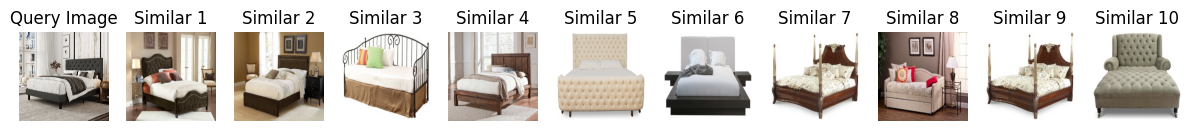

In [81]:
import matplotlib.pyplot as plt
from PIL import Image


num_images = len(responses) + 1  # +1 for the query image
plt.figure(figsize=(15, 5))

# Plot the query image
plt.subplot(1, num_images, 1)
plt.imshow(Image.open(query_path))
plt.axis("off")
plt.title("Query Image")

# Plot similar images
for i, img_path in enumerate(responses, start=2):
    plt.subplot(1, num_images, i)
    plt.imshow(Image.open(img_path))
    plt.axis("off")
    plt.title(f"Similar {i-1}")

plt.show()
